In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import expipe
import pathlib
import numpy as np
import spatial_maps.stats as stats
import septum_mec.analysis.data_processing as dp
from septum_mec.analysis.registration import store_notebook
import head_direction.head as head
import spatial_maps as sp
import pnnmec.registration
import speed_cells.speed as spd
import re
import joblib
import multiprocessing
import shutil
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import pnnmec
import scipy.ndimage.measurements
import quantities as pq
import exdir
from tqdm import tqdm_notebook as tqdm
import networkx as nx
from nxpd import draw
%matplotlib inline

14:11:16 [I] klustakwik KlustaKwik2 version 0.2.6


In [3]:
project_path = dp.project_path()

# project = expipe.get_project(project_path)
project = expipe.get_project('/media/storage/expipe/septum-mec-gitea/')
actions = project.actions

/home/mikkel/apps/expipe-project/cinpla-base/src/expipe/expipe/core.py:693: UserWarning: Requested project with name 'septum-mec-gitea', but found 'septum-mec'
  "'{}', but found '{}'".format(name, project))


In [4]:
identify_neurons = project.require_action('identify-neurons')

In [5]:
actions['1833-010719-2'].attributes

{'users': ['Charlotte'],
 'tags': ['11hz', 'open-ephys', 'septum'],
 'datetime': '2019-07-01T12:54:49',
 'type': 'Recording',
 'registered': '2019-07-02T14:53:28',
 'data': {'main': 'main.exdir'},
 'location': 'IMB',
 'entities': ['1833']}

In [6]:
actions['1833-010719-1'].attributes

{'users': ['Charlotte'],
 'tags': ['baseline I', 'open-ephys', 'septum'],
 'datetime': '2019-07-01T12:25:01',
 'type': 'Recording',
 'registered': '2019-07-02T14:53:03',
 'data': {'main': 'main.exdir'},
 'location': 'IMB',
 'entities': ['1833']}

In [7]:
sessions = []
for action in actions.values():
    if action.type != 'Recording':
        continue
    action_data_path = pathlib.Path(action.data_path('main'))        
    if not 'electrophysiology' in exdir.File(action_data_path)['processing']:
        continue
    tags = [t.lower() for t in action.tags]
    
    location, freq = [np.nan] * 2
    stimulated = False
    baseline = False
    
    if '11hz' in tags:
        stimulated = True
        freq = 11
    if '30hz' in tags:
        stimulated = True
        freq = 30
    
    tag = ""
    stim_location = ""
    tag_i = [i for i, t in enumerate(tags) if 'baseline' in t or 'stim' in t]
    if len(tag_i) == 1:
        tag = tags[tag_i[0]]
        if 'stim' in tag:
            stim_location = tag.split('-')[-1]
            stimulated = True
        if 'baseline' in tag:
            baseline = True
        
    

    sessions.append({
        'tag': tag,
        'action': action.id,
        'stimulated': stimulated,
        'baseline': baseline,
        'frequency': freq,
        'session': int(action.id.split('-')[-1]),
        'stim_location': stim_location,
        'entity': int(action.entities[0]),

    })
sessions = pd.DataFrame(sessions)

In [8]:
sessions.query('not stimulated and not baseline')

,action,baseline,entity,frequency,session,stim_location,stimulated,tag
4,1834-150319-3,False,1834,NaN,3,,False,
5,1834-120319-4,False,1834,NaN,4,,False,
7,1849-110319-2,False,1849,NaN,2,,False,
12,1834-120319-2,False,1834,NaN,2,,False,
15,1834-150319-4,False,1834,NaN,4,,False,
17,1834-150319-1,False,1834,NaN,1,,False,
24,1839-290519-1,False,1839,NaN,1,,False,
25,1834-110319-3,False,1834,NaN,3,,False,
26,1833-290519-3,False,1833,NaN,3,,False,
28,1834-150319-2,False,1834,NaN,2,,False,


In [80]:
from septum_mec.analysis.trackunitmulticomparison import TrackMultipleSessions

In [91]:
unit_matching = TrackMultipleSessions(
    list(sessions.query('entity==1834').action)[:3], 
    actions, progress_bar=tqdm, verbose=False, data_path='output/identify_neurons/1834-graphs'
)
unit_matching.save_graph()

In [93]:
unit_matching.redo_match(.035)

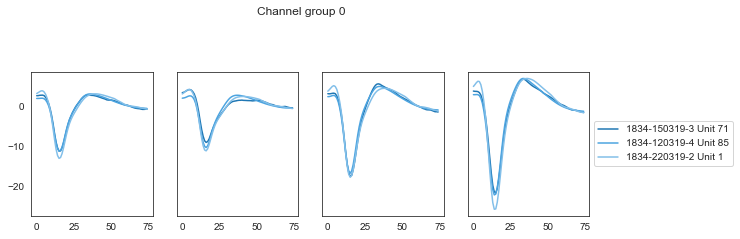

<Figure size 720x0 with 0 Axes>

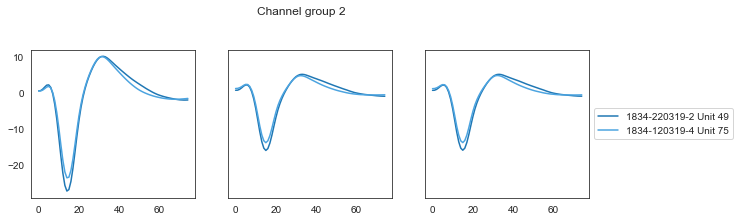

<Figure size 720x0 with 0 Axes>

<Figure size 720x0 with 0 Axes>

<Figure size 720x0 with 0 Axes>

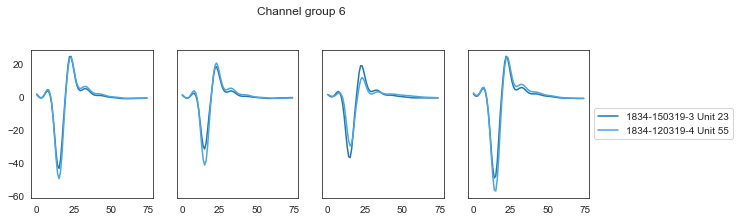

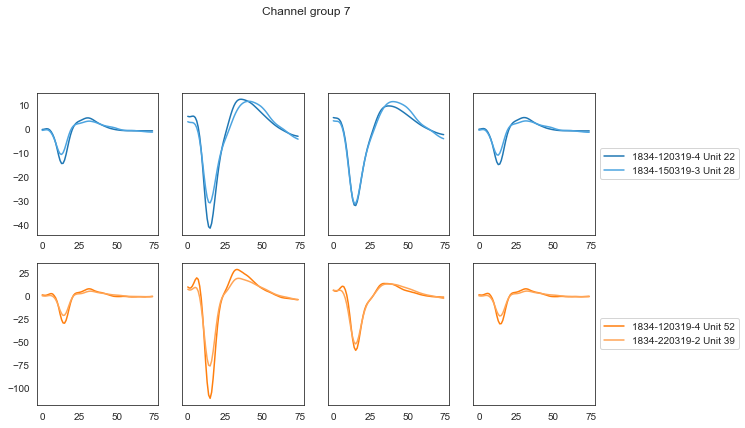

In [94]:
unit_matching.plot_matches('template')

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/networkx/classes/graph.py:771: DeprecationWarning: number_of_selfloops is deprecated.Use nx.number_of_selfloops instead.
  warnings.warn(msg, DeprecationWarning)


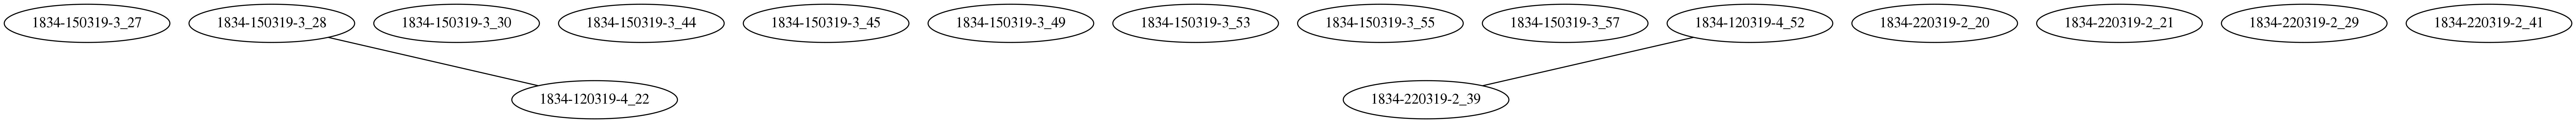

In [69]:
G = unit_matching.graphs[7]
G.graph['dpi'] = 300
draw(G, show='ipynb')

In [70]:
for ch, G in unit_matching.graphs.items():
    print(f'\nchannel group {ch}')
    for (n1, n2), d in G.edges.items():
        print(n1, n2, d)


channel group 0
1834-150319-3_71 1834-120319-4_85 {'weight': 0.023163134330836832}
1834-150319-3_71 1834-220319-2_1 {'weight': 0.028137051531366416}
1834-120319-4_85 1834-220319-2_1 {'weight': 0.0332596397926616}

channel group 1

channel group 2
1834-120319-4_75 1834-220319-2_49 {'weight': 0.029485645381389522}

channel group 3

channel group 4

channel group 5

channel group 6
1834-150319-3_23 1834-120319-4_55 {'weight': 0.025708909930283602}

channel group 7
1834-150319-3_28 1834-120319-4_22 {'weight': 0.032109985701644014}
1834-120319-4_52 1834-220319-2_39 {'weight': 0.02535298260751605}


In [90]:
G.edges('1834-150319-3_71', data=True)

EdgeDataView([('1834-150319-3_71', '1834-120319-4_85', {'weight': 0.023163134330836832}), ('1834-150319-3_71', '1834-220319-2_1', {'weight': 0.028137051531366416})])

In [105]:
pd.DataFrame(units).to_csv('1834-units.csv')

,action_id,unit_id,unit_name
0,1834-150319-3,fa245677-31a9-434b-bbf1-b121ff80ed20,71
1,1834-120319-4,fa245677-31a9-434b-bbf1-b121ff80ed20,85
2,1834-220319-2,fa245677-31a9-434b-bbf1-b121ff80ed20,1
3,1834-150319-3,8227aa12-10d3-4131-9492-a01c496c98db,75
4,1834-220319-2,7c5bd8b6-79cb-4f4c-8cea-563e5bdc2f05,49
5,1834-120319-4,7c5bd8b6-79cb-4f4c-8cea-563e5bdc2f05,75
6,1834-220319-2,662958db-4b31-4d3a-82e4-d4b172156a4c,7
7,1834-150319-3,a560880a-1f54-4e8b-a327-59dff681dea8,61
8,1834-150319-3,992b4d7f-d048-465c-9e6c-54f9582644f3,8
9,1834-120319-4,7f812c1d-7c9b-4b59-9c6d-46c10db02a5e,59


In [135]:
units = []
for action in actions.values():
    if action.type != 'Recording':
        continue
    

# Store results in Expipe action

In [64]:
identify_neurons.data['sessions'] = 'sessions.csv'
identify_neurons.data['units'] = 'units.csv'

In [67]:
sessions.to_csv(identify_neurons.data_path('sessions'), index=False)

In [69]:
store_notebook(
    identify_neurons, "00-identify-neurons.ipynb")

In [ ]:
n = 0
for i in range(5):
    for j in range(i+1,5):
        n += 1

In [34]:
import hashlib
hash_object = hashlib.sha1('Hello World'.encode())
hex_dig = hash_object.hexdigest()
print(type(hex_dig))

<class 'str'>


In [37]:
inv_hex = hashlib.sha1(hex_dig.encode())

In [43]:
'Hello World'.decode('hex')

AttributeError: 'str' object has no attribute 'decode'

In [16]:
import binascii

In [23]:
h = binascii.hexlify('1834-150319-3'.encode())

h

b'313833342d3135303331392d33'

In [24]:
binascii.a2b_hex(h).decode()

'1834-150319-3'

In [27]:
h + ('_' + str(11)).encode()

b'313833342d3135303331392d33_11'

'75c95dd5-b6bf-4a77-952e-742866b31c4d'